In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb
from tqdm import tqdm

#### Output file

In [2]:
sourceFile = open("gpu_logs/cluster2.txt", 'w')

### Load the data

In [3]:
df = pd.read_csv("data/porto_cluster2_loc.csv")
## Leaving the first house (public building out) due to its different profile
df['Energy'] = df['Energy'].astype(np.float32)
df = df.iloc[:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
df['Time'] = pd.to_datetime(df['Time'])
df.reset_index(drop=True, inplace=True)
df

,Time,Location,Energy
0,2019-01-01 00:00:00,1,2.322959
1,2019-01-01 00:15:00,1,2.371797
2,2019-01-01 00:30:00,1,2.415961
3,2019-01-01 00:45:00,1,2.302538
4,2019-01-01 01:00:00,1,2.363063
...,...,...,...
456763,2020-01-01 22:45:00,37,2.559163
456764,2020-01-01 23:00:00,37,2.435601
456765,2020-01-01 23:15:00,37,2.499977
456766,2020-01-01 23:30:00,37,1.648652


In [14]:
#trunc = lambda x: math.trunc(10000 * x) / 10000
#df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
#df = pd.concat([df.iloc[:, 0:-1], df_trunc], axis=1)
#df

### Auxiliary functions

In [4]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    print('MSE: %.4f' % mse)
    print('WAPE: %.2f' % wape)
    print('R2: %.4f' % r2)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [5]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)))
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)))
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)))

def past_timesteps(df, number_of_timesteps):
    df = df.sort_values(by=['Location', 'Time'])
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

#def past_timesteps(df, number_of_timesteps):
#    # Sort the dataframe by location and time
#    df = df.sort_values(by=['Location', 'Time'])
#
#    # Compute rolling window over time axis to extract past energy values for each location
#    energy_lags = [f"energy_lag_{i}" for i in range(1, number_of_timesteps+1)]
#    past_energy = df.groupby('Location')['Energy'].rolling(window=number_of_timesteps, min_periods=1).apply(np.mean())
#    # Add new columns to the dataframe for each past energy value
#    for i, energy_lag in enumerate(energy_lags):
#        df[energy_lag] = past_energy.apply(lambda x: x[-i-1] if isinstance(x, list) and len(x)>=i+1 else x)
#
#    # Drop rows with missing values
#    df.dropna(inplace=True)
#    df.reset_index(drop=True, inplace=True)
#
#    return df


def last_energy_points_full(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    other_feats = df.iloc[:,:2]
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = df.copy().iloc[:,2]
    y.iloc[:number_timesteps] = np.nan
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X = pd.concat([other_feats, X], axis=1)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    dataframe = pd.concat([X,y.rename('Energy')], axis=1)
    assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
    return dataframe
    

In [6]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [7]:
def test_leave_house_out(df, estimator, locations, filename):
    test = df[df['Location'].isin(locations)]
    train = df[~df['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)
    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Save Dataframe with past timesteps

In [8]:
number_of_timesteps = 96

In [9]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

100%|██████████| 96/96 [00:00<00:00, 163.39it/s]


,Time,Location,Energy,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96
0,2019-01-02 00:00:00,1,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,0.478296,...,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959
1,2019-01-02 00:15:00,1,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,...,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797
2,2019-01-02 00:30:00,1,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,...,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961
3,2019-01-02 00:45:00,1,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,...,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538
4,2019-01-02 01:00:00,1,0.414080,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,...,2.378686,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455515,2020-01-01 22:45:00,37,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,3.404035,1.876841,...,3.445410,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955,3.178231,2.557900,2.181046
455516,2020-01-01 23:00:00,37,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,3.404035,...,3.488046,3.445410,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955,3.178231,2.557900
455517,2020-01-01 23:15:00,37,2.499977,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,...,2.883564,3.488046,3.445410,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955,3.178231
455518,2020-01-01 23:30:00,37,1.648652,2.499977,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,...,3.928995,2.883564,3.488046,3.445410,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955


In [10]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

,Time,Location,Energy,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,DayOfWeek,Weekend,Hour
0,2019-01-02 00:00:00,1,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,0.478296,...,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959,2,0,0
1,2019-01-02 00:15:00,1,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,...,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2,0,0
2,2019-01-02 00:30:00,1,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,...,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2,0,0
3,2019-01-02 00:45:00,1,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,...,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2,0,0
4,2019-01-02 01:00:00,1,0.414080,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,...,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455515,2020-01-01 22:45:00,37,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,3.404035,1.876841,...,2.918065,2.996325,3.661677,2.431955,3.178231,2.557900,2.181046,2,0,22
455516,2020-01-01 23:00:00,37,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,3.404035,...,3.678226,2.918065,2.996325,3.661677,2.431955,3.178231,2.557900,2,0,23
455517,2020-01-01 23:15:00,37,2.499977,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,...,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955,3.178231,2,0,23
455518,2020-01-01 23:30:00,37,1.648652,2.499977,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,...,3.445410,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955,2,0,23


In [11]:
df_new.to_csv("data/porto_cluster2_96.csv", index=False)

## Predict  10 folds with 10 random houses for test

In [12]:
df_test = pd.read_csv("data/porto_cluster2_96.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df = pd.read_csv("data/porto_cluster2_96.csv", engine='c', dtype=float32_cols)
df

,Time,Location,Energy,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,DayOfWeek,Weekend,Hour
0,2019-01-02 00:00:00,1,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,0.478296,...,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959,2,0,0
1,2019-01-02 00:15:00,1,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,0.421338,...,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2,0,0
2,2019-01-02 00:30:00,1,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,0.349619,...,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2,0,0
3,2019-01-02 00:45:00,1,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,0.455415,...,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2,0,0
4,2019-01-02 01:00:00,1,0.414080,0.407560,0.521968,0.372131,0.345928,0.478050,0.350111,0.377052,...,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455515,2020-01-01 22:45:00,37,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,3.404035,1.876841,...,2.918065,2.996325,3.661677,2.431955,3.178231,2.557900,2.181046,2,0,22
455516,2020-01-01 23:00:00,37,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,3.404035,...,3.678226,2.918065,2.996325,3.661677,2.431955,3.178231,2.557900,2,0,23
455517,2020-01-01 23:15:00,37,2.499977,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,1.588484,...,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955,3.178231,2,0,23
455518,2020-01-01 23:30:00,37,1.648652,2.499977,2.435601,2.559163,3.734327,1.542202,1.636871,1.641640,...,3.445410,3.471637,3.678226,2.918065,2.996325,3.661677,2.431955,2,0,23


In [13]:
#df = df[["Time", "Location", "energy_lag_1", "energy_lag_3", "energy_lag_95", "energy_lag_671", "Energy"]]
#df

In [14]:
num_houses_test = 10
locations = []
for i in range(10):
    np.random.seed(i*5)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array([12, 33,  9, 32,  5, 29,  4, 23, 30,  7]),
 array([11,  4, 23,  5, 30, 37, 32,  9, 29,  1]),
 array([ 7, 23, 33, 12, 29,  5, 37, 11, 32,  4]),
 array([32,  5, 37, 30,  4, 12,  7,  9,  1, 23]),
 array([23,  4, 29, 11,  1,  5, 12, 37,  9, 30]),
 array([33, 29,  7,  4, 30, 37,  1, 11,  5, 23]),
 array([ 1, 29, 32, 30, 12,  4,  7, 33,  5, 23]),
 array([12,  9,  5, 32, 11, 37, 33,  7, 29,  1]),
 array([32, 30, 37,  7,  9,  4,  5,  1, 29, 11]),
 array([30, 29, 23,  5, 12, 32,  4,  9, 37, 11])]

In [15]:
## Number of NaNs
df.isna().sum().sum()

0

In [16]:
#kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
#locations = []
#for _, test_index in kf.split(df['Location'].unique()):
#    locations.append(test_index)
#locations

In [17]:
df.Location.value_counts()

1     35040
4     35040
5     35040
7     35040
9     35040
11    35040
12    35040
23    35040
29    35040
30    35040
32    35040
33    35040
37    35040
Name: Location, dtype: int64

### Linear Regression

In [18]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))


Iteration 0
Train set:  (105120, 102)
Test set:  (350400, 102)
MSE: 0.4434
WAPE: 32.47
R2: 0.7335

Iteration 1
Train set:  (105120, 102)
Test set:  (350400, 102)
MSE: 0.4530
WAPE: 33.76
R2: 0.7014

Iteration 2
Train set:  (105120, 102)
Test set:  (350400, 102)
MSE: 0.4285
WAPE: 32.52
R2: 0.7326

Iteration 3
Train set:  (105120, 102)
Test set:  (350400, 102)
MSE: 0.4446
WAPE: 32.71
R2: 0.7370

Iteration 4
Train set:  (105120, 102)
Test set:  (350400, 102)
MSE: 0.4461
WAPE: 32.76
R2: 0.7387


### XGBoost

In [19]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))


Iteration 0
Train set:  (105120, 102)
Test set:  (350400, 102)
MSE: 0.4152
WAPE: 31.61
R2: 0.7504

Iteration 1
Train set:  (105120, 102)
Test set:  (350400, 102)
MSE: 0.3627
WAPE: 29.59
R2: 0.7609

Iteration 2
Train set:  (105120, 102)
Test set:  (350400, 102)
MSE: 0.4134
WAPE: 31.80
R2: 0.7420

Iteration 3
Train set:  (105120, 102)
Test set:  (350400, 102)
MSE: 0.4061
WAPE: 30.47
R2: 0.7598

Iteration 4
Train set:  (105120, 102)
Test set:  (350400, 102)
MSE: 0.4440
WAPE: 32.27
R2: 0.7400


### Random Forest

In [20]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))


Iteration 0
Train set:  (105120, 102)
Test set:  (350400, 102)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.3897
WAPE: 29.81
R2: 0.7657

Iteration 1
Train set:  (105120, 102)
Test set:  (350400, 102)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.3592
WAPE: 28.99
R2: 0.7632

Iteration 2
Train set:  (105120, 102)
Test set:  (350400, 102)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.3901
WAPE: 30.61
R2: 0.7565

Iteration 3
Train set:  (105120, 102)
Test set:  (350400, 102)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


MSE: 0.3885
WAPE: 29.56
R2: 0.7702

Iteration 4
Train set:  (105120, 102)
Test set:  (350400, 102)
MSE: 0.4392
WAPE: 31.23
R2: 0.7428


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [21]:
print("\n\n\n", file=sourceFile)

In [22]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

Total Averaged MSE: 0.443
Total Averaged WAPE: 32.844
Total Averaged R2: 0.729


In [23]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

Total Averaged MSE: 0.408
Total Averaged WAPE: 31.148
Total Averaged R2: 0.751


In [24]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

Total Averaged MSE: 0.393
Total Averaged WAPE: 30.04
Total Averaged R2: 0.76


In [25]:
sourceFile.close()

### Feature Importance

In [36]:
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

XGBoost

Feature: 0, Score: 0.41826
Feature: 1, Score: 0.01194
Feature: 2, Score: 0.01694
Feature: 3, Score: 0.00439
Feature: 4, Score: 0.01128
Feature: 5, Score: 0.00976
Feature: 6, Score: 0.00623
Feature: 7, Score: 0.00479
Feature: 8, Score: 0.00501
Feature: 9, Score: 0.00434
Feature: 10, Score: 0.00374
Feature: 11, Score: 0.00487
Feature: 12, Score: 0.00419
Feature: 13, Score: 0.00394
Feature: 14, Score: 0.00434
Feature: 15, Score: 0.00414
Feature: 16, Score: 0.00407
Feature: 17, Score: 0.00311
Feature: 18, Score: 0.00393
Feature: 19, Score: 0.00454
Feature: 20, Score: 0.00481
Feature: 21, Score: 0.00546
Feature: 22, Score: 0.00288
Feature: 23, Score: 0.00367
Feature: 24, Score: 0.00316
Feature: 25, Score: 0.00454
Feature: 26, Score: 0.00370
Feature: 27, Score: 0.01264
Feature: 28, Score: 0.00774
Feature: 29, Score: 0.00474
Feature: 30, Score: 0.00522
Feature: 31, Score: 0.00448
Feature: 32, Score: 0.00654
Feature: 33, Score: 0.00478
Feature: 34, Score: 0.00411
Feature: 35, Score: 0

In [37]:
model_xgb.feature_importances_

array([0.4182579 , 0.01193606, 0.01694158, 0.00438902, 0.01128068,
       0.0097647 , 0.00623326, 0.00479079, 0.00500899, 0.00434484,
       0.00373787, 0.00487428, 0.00419007, 0.00393672, 0.00433833,
       0.00414164, 0.00406683, 0.00311182, 0.00392868, 0.00454335,
       0.00480778, 0.00546431, 0.00288309, 0.0036705 , 0.00316156,
       0.00454054, 0.00369548, 0.01263935, 0.00774393, 0.00473747,
       0.00522031, 0.0044817 , 0.00653969, 0.00477822, 0.00411319,
       0.00379107, 0.00563563, 0.0045162 , 0.00952921, 0.00384848,
       0.00388172, 0.005981  , 0.00697904, 0.00670283, 0.00294231,
       0.00375883, 0.00390404, 0.00284017, 0.00292144, 0.00427279,
       0.00297741, 0.00302794, 0.00358698, 0.00314531, 0.00295649,
       0.00361059, 0.00316578, 0.00266437, 0.00456036, 0.00383232,
       0.00414353, 0.00520567, 0.00395837, 0.00451   , 0.00458315,
       0.00309692, 0.00476269, 0.01106183, 0.01395799, 0.00434367,
       0.00366469, 0.00442595, 0.00303235, 0.00410005, 0.00506

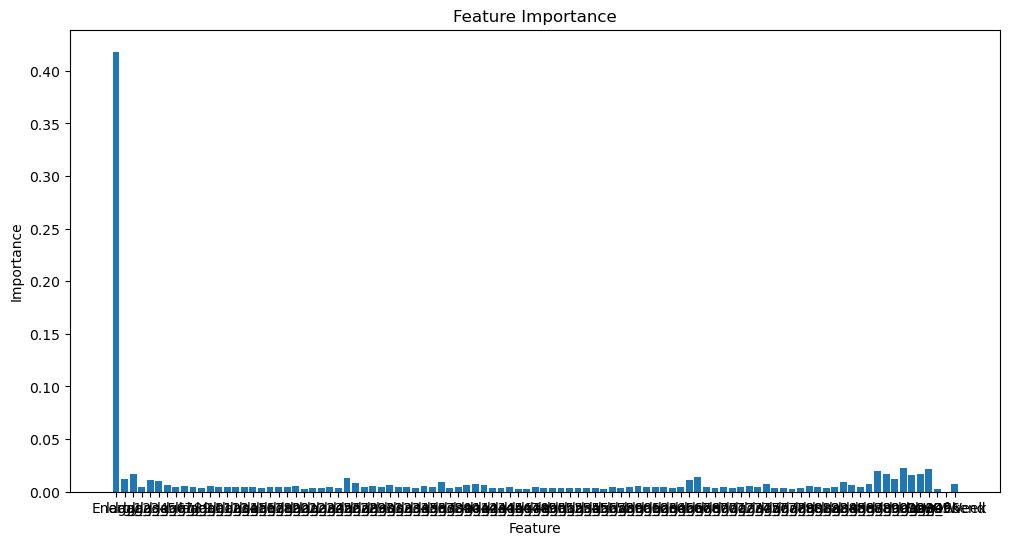

In [38]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[2:-1],model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.savefig("images/porto_xgb_last2hours_feature_importance.png")
plt.show()

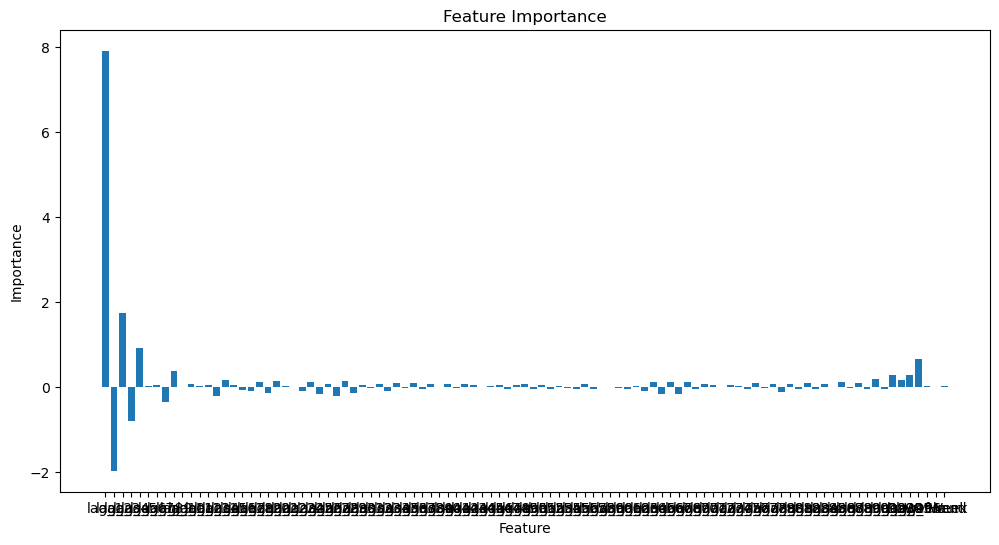

In [39]:
plt.figure(figsize=(12,6))
plt.bar(df.columns[3:],model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [40]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

lag_1        0.418258
lag_2        0.011936
lag_3        0.016942
lag_4        0.004389
lag_5        0.011281
               ...   
lag_95       0.016826
lag_96       0.021923
DayOfWeek    0.002853
Weekend      0.000000
Hour         0.007056
Length: 99, dtype: float32

In [41]:
features = feature_importance.nlargest(40).index
features

Index(['lag_1', 'lag_93', 'lag_96', 'lag_90', 'lag_3', 'lag_95', 'lag_91',
       'lag_94', 'lag_69', 'lag_28', 'lag_92', 'lag_2', 'lag_5', 'lag_68',
       'lag_6', 'lag_39', 'lag_86', 'lag_29', 'lag_89', 'lag_77', 'Hour',
       'lag_43', 'lag_44', 'lag_33', 'lag_7', 'lag_42', 'lag_87', 'lag_37',
       'lag_82', 'lag_22', 'lag_31', 'lag_62', 'lag_75', 'lag_9', 'lag_12',
       'lag_21', 'lag_8', 'lag_34', 'lag_67', 'lag_30'],
      dtype='object')

In [42]:
df_40 = df[['Time', 'Location'] + [*features] + ['Energy']]
df_40

,Time,Location,lag_1,lag_93,lag_96,lag_90,lag_3,lag_95,lag_91,lag_94,...,lag_62,lag_75,lag_9,lag_12,lag_21,lag_8,lag_34,lag_67,lag_30,Energy
0,2019-01-02 00:00:00,2,0.150346,1.319880,1.544608,0.997031,0.064886,1.544608,0.913154,1.319880,...,0.395647,0.229475,0.363996,0.468447,0.159842,0.378239,2.864487,0.270623,0.634618,0.337092
1,2019-01-02 00:15:00,2,0.337092,0.913154,1.544608,0.997031,0.150346,1.319880,0.997031,1.319880,...,0.395647,0.259545,0.378239,0.468447,0.063304,0.378239,2.864487,0.261127,0.634618,0.337092
2,2019-01-02 00:30:00,2,0.337092,0.913154,1.319880,1.074578,0.150346,1.319880,0.997031,0.913154,...,0.403560,0.259545,0.378239,0.363996,0.063304,0.123442,0.398813,0.261127,0.522255,0.363996
3,2019-01-02 00:45:00,2,0.363996,0.997031,1.319880,1.074578,0.337092,0.913154,1.074578,0.913154,...,0.403560,0.164589,0.123442,0.363996,0.288031,0.123442,0.398813,0.341839,0.522255,0.363996
4,2019-01-02 01:00:00,2,0.363996,0.997031,0.913154,0.508011,0.337092,0.913154,1.074578,0.997031,...,0.259545,0.164589,0.123442,0.378239,0.288031,0.064886,0.634618,0.341839,0.914737,0.278536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296475,2020-01-01 22:45:00,50,1.099100,0.715781,0.641933,0.858855,0.481770,0.752850,0.881889,0.935428,...,1.031567,0.499932,0.533451,0.937120,0.873592,0.533286,0.321565,0.484824,0.335393,0.753222
1296476,2020-01-01 23:00:00,50,0.753222,1.077717,0.752850,1.082588,0.453906,0.935428,0.858855,0.715781,...,0.809237,0.482471,0.533286,0.552398,0.515247,0.552398,0.414113,0.516137,0.467735,0.716855
1296477,2020-01-01 23:15:00,50,0.716855,0.881889,0.935428,1.021784,1.099100,0.715781,1.082588,1.077717,...,0.676029,0.475413,0.552398,0.464143,0.472482,1.001887,0.297128,1.295506,0.285858,0.735802
1296478,2020-01-01 23:30:00,50,0.735802,0.858855,0.715781,1.014065,0.753222,1.077717,1.021784,0.881889,...,0.779599,0.514710,1.001887,0.533451,0.421461,0.467528,1.031650,1.310532,0.605112,0.485237


In [ ]:
df_40.to_csv("data/porto_best40features.csv", index=False)

### Test with 40 best features

In [ ]:
sourceFile = open("gpu_logs/ensemble_porto_40best.txt", 'w')

In [ ]:
df_test = pd.read_csv("data/porto_best40features.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df_40 = pd.read_csv("data/porto_best40features.csv", engine='c', dtype=float32_cols)
df_40

In [ ]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df_40, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

In [ ]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df_40, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

In [ ]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df_40, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

In [ ]:
print("\n\n\n", file=sourceFile)

In [ ]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [ ]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [ ]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

In [ ]:
sourceFile.close()